In [1]:
import numpy as np
import cv2
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
def create_background_mask(frame, ground_truth_bg, threshold=7):
    """
    Create training mask by comparing frame pixels to ground truth background.
    Accounts for lighting differences due to virtual background filtering.
    """
    # Convert to LAB color space for better perceptual comparison
    frame_lab = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
    bg_lab = cv2.cvtColor(ground_truth_bg, cv2.COLOR_BGR2LAB)
    print("Frame shape:", frame.shape)
    print("Background shape:", ground_truth_bg.shape)
    print("Frame LAB shape:", frame_lab.shape)
    print("Background LAB shape:", bg_lab.shape)
    
    # Calculate pixel-wise difference
    diff = np.linalg.norm(frame_lab.astype(float) - bg_lab.astype(float), axis=2)
    
    # Create mask: 1 for similar pixels (real background), 0 for different
    background_mask = (diff < threshold).astype(np.uint8)
    
    # Apply morphological operations to clean up noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    background_mask = cv2.morphologyEx(background_mask, cv2.MORPH_CLOSE, kernel)
    background_mask = cv2.morphologyEx(background_mask, cv2.MORPH_OPEN, kernel)
    
    return background_mask

In [3]:
# load a sample
from util import (load_video, load_background, load_mask, metric_CIEDE2000, evaluate, load_triplets)

video_triplets = load_triplets("data/public/backgrounds", "data/public/videos", "data/public/masks")
video_sample_idx = 3
# print(video_triplets[video_sample_idx])
sample = video_triplets[video_sample_idx]

video = dict(
    video=np.array(load_video(sample[0])),
    mask=load_mask(sample[1]),
    background=load_background(sample[2])
)
print(f"{sample[0]}")

data/public/videos/2_i_kitchen_bridge_mp.mp4


Frame shape: (720, 1280, 3)
Background shape: (720, 1280, 3)
Frame LAB shape: (720, 1280, 3)
Background LAB shape: (720, 1280, 3)


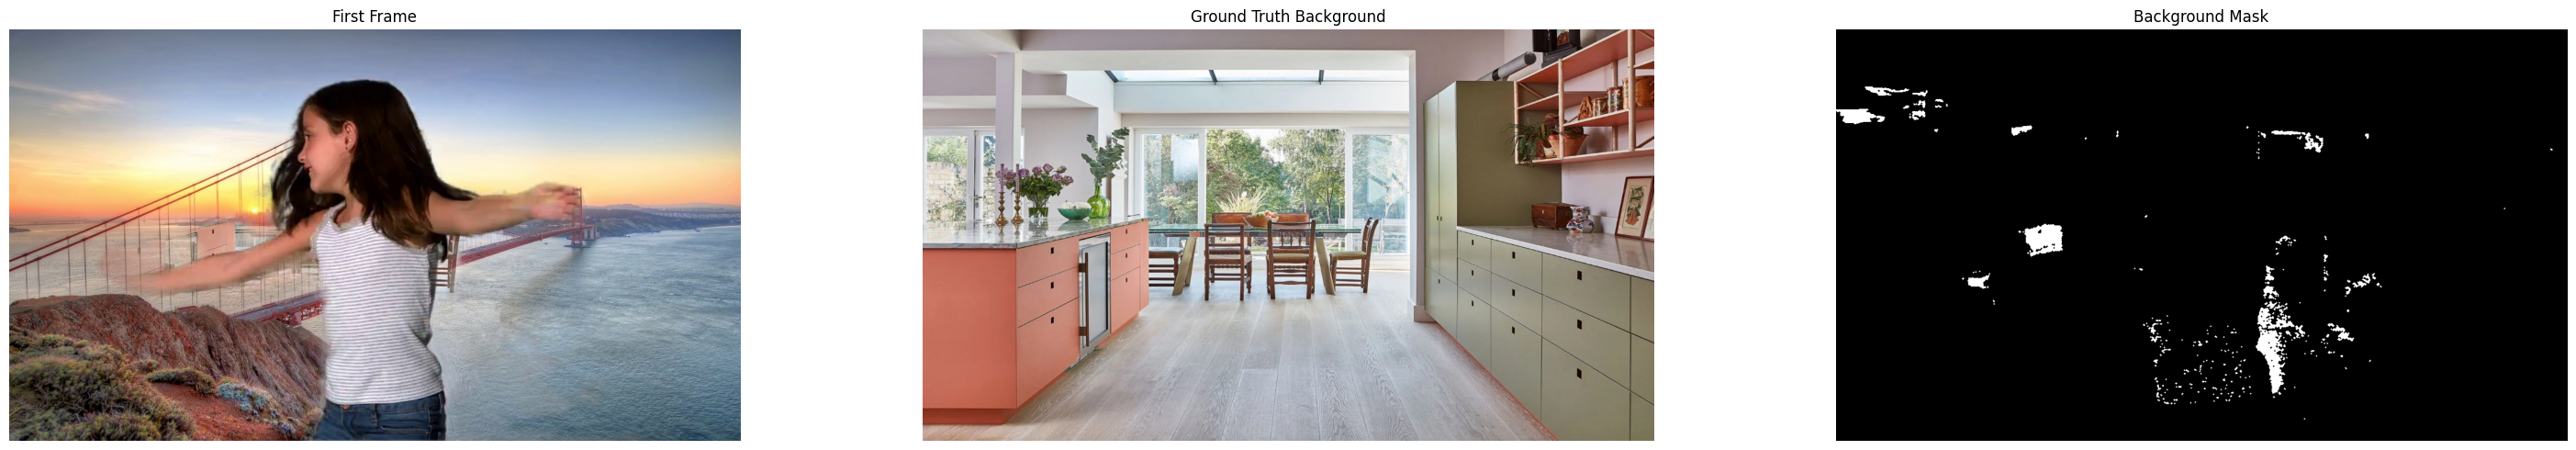

In [4]:
import matplotlib.pyplot as plt
first_frame = video["video"][0]
ground_truth_bg = video["background"]
background_mask = create_background_mask(first_frame, ground_truth_bg)

plt.figure(figsize=(30, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB))
plt.title("First Frame")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(ground_truth_bg, cv2.COLOR_BGR2RGB))
plt.title("Ground Truth Background")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(background_mask, cmap='gray')
plt.title("Background Mask")
plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
import numpy as np
import cv2
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

def create_continuous_similarity_mask(frame, ground_truth_bg, method='combined'):
    """
    Create continuous similarity measures instead of binary masks.
    Returns values between 0 (dissimilar) and 1 (very similar).
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Convert to different color spaces for robust comparison
    frame_lab = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB).astype(np.float32)
    bg_lab = cv2.cvtColor(ground_truth_bg, cv2.COLOR_BGR2LAB).astype(np.float32)
    
    frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV).astype(np.float32)
    bg_hsv = cv2.cvtColor(ground_truth_bg, cv2.COLOR_BGR2HSV).astype(np.float32)
    
    if method == 'perceptual_distance':
        # Perceptual distance in LAB space (normalized)
        diff_lab = np.linalg.norm(frame_lab - bg_lab, axis=2)
        similarity = np.exp(-diff_lab / 50.0)  # Exponential decay
        
    elif method == 'cosine_similarity': # don't use this, it's slow
        # Cosine similarity between pixel vectors
        h, w, c = frame.shape
        frame_flat = frame.reshape(-1, c).astype(np.float32)
        bg_flat = ground_truth_bg.reshape(-1, c).astype(np.float32)
        
        # Compute cosine similarity for each pixel
        similarities = []
        for i in tqdm(range(frame_flat.shape[0])):
            sim = cosine_similarity([frame_flat[i]], [bg_flat[i]])[0][0]
            similarities.append(max(0, sim))  # Ensure non-negative
        
        similarity = np.array(similarities).reshape(h, w)
        
    elif method == 'combined':
        # Combine multiple similarity measures
        # LAB distance component
        diff_lab = np.linalg.norm(frame_lab - bg_lab, axis=2)
        sim_lab = np.exp(-diff_lab / 40.0)
        
        # HSV distance component (focus on hue and saturation)
        diff_hsv = np.linalg.norm(frame_hsv[:,:,:2] - bg_hsv[:,:,:2], axis=2)
        sim_hsv = np.exp(-diff_hsv / 30.0)
        
        # Structural similarity component
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        bg_gray = cv2.cvtColor(ground_truth_bg, cv2.COLOR_BGR2GRAY)
        
        # Local structural similarity using sliding window
        kernel_size = 7
        kernel = np.ones((kernel_size, kernel_size), np.float32) / (kernel_size * kernel_size)
        
        frame_mean = cv2.filter2D(frame_gray.astype(np.float32), -1, kernel)
        bg_mean = cv2.filter2D(bg_gray.astype(np.float32), -1, kernel)
        
        frame_var = cv2.filter2D((frame_gray.astype(np.float32) - frame_mean)**2, -1, kernel)
        bg_var = cv2.filter2D((bg_gray.astype(np.float32) - bg_mean)**2, -1, kernel)
        
        covar = cv2.filter2D((frame_gray.astype(np.float32) - frame_mean) * 
                           (bg_gray.astype(np.float32) - bg_mean), -1, kernel)
        
        # SSIM-like measure
        c1, c2 = 0.01**2, 0.03**2
        ssim = ((2 * frame_mean * bg_mean + c1) * (2 * covar + c2)) / \
               ((frame_mean**2 + bg_mean**2 + c1) * (frame_var + bg_var + c2))
        
        ssim = np.clip(ssim, 0, 1)
        
        # Weighted combination
        similarity = 0.4 * sim_lab + 0.3 * sim_hsv + 0.3 * ssim
        
    # Apply soft morphological operations to reduce noise
    similarity = cv2.GaussianBlur(similarity.astype(np.float32), (5, 5), 1.0)
    
    return np.clip(similarity, 0, 1)

/tmp/ipykernel_1182462/955049540.py:17: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


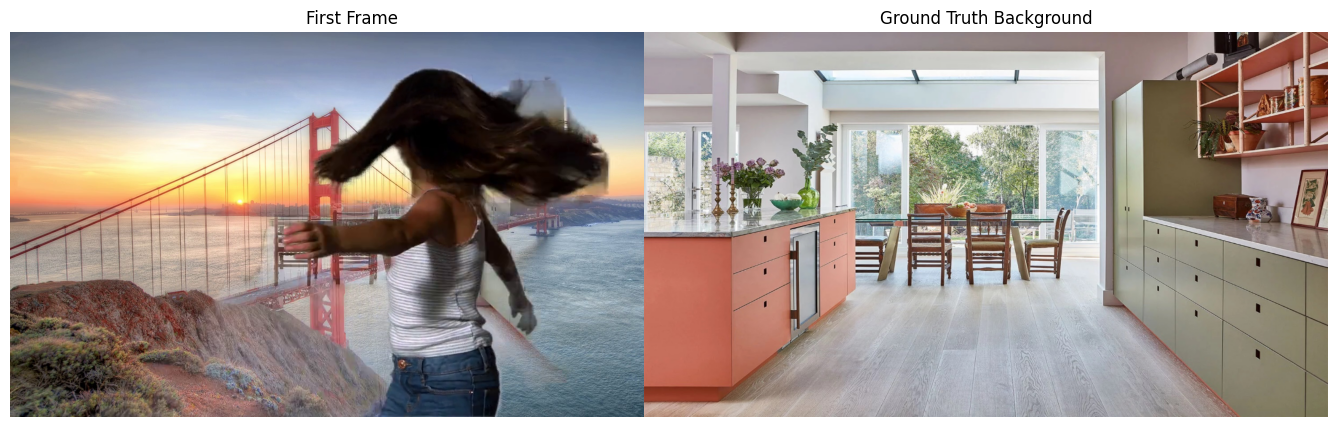

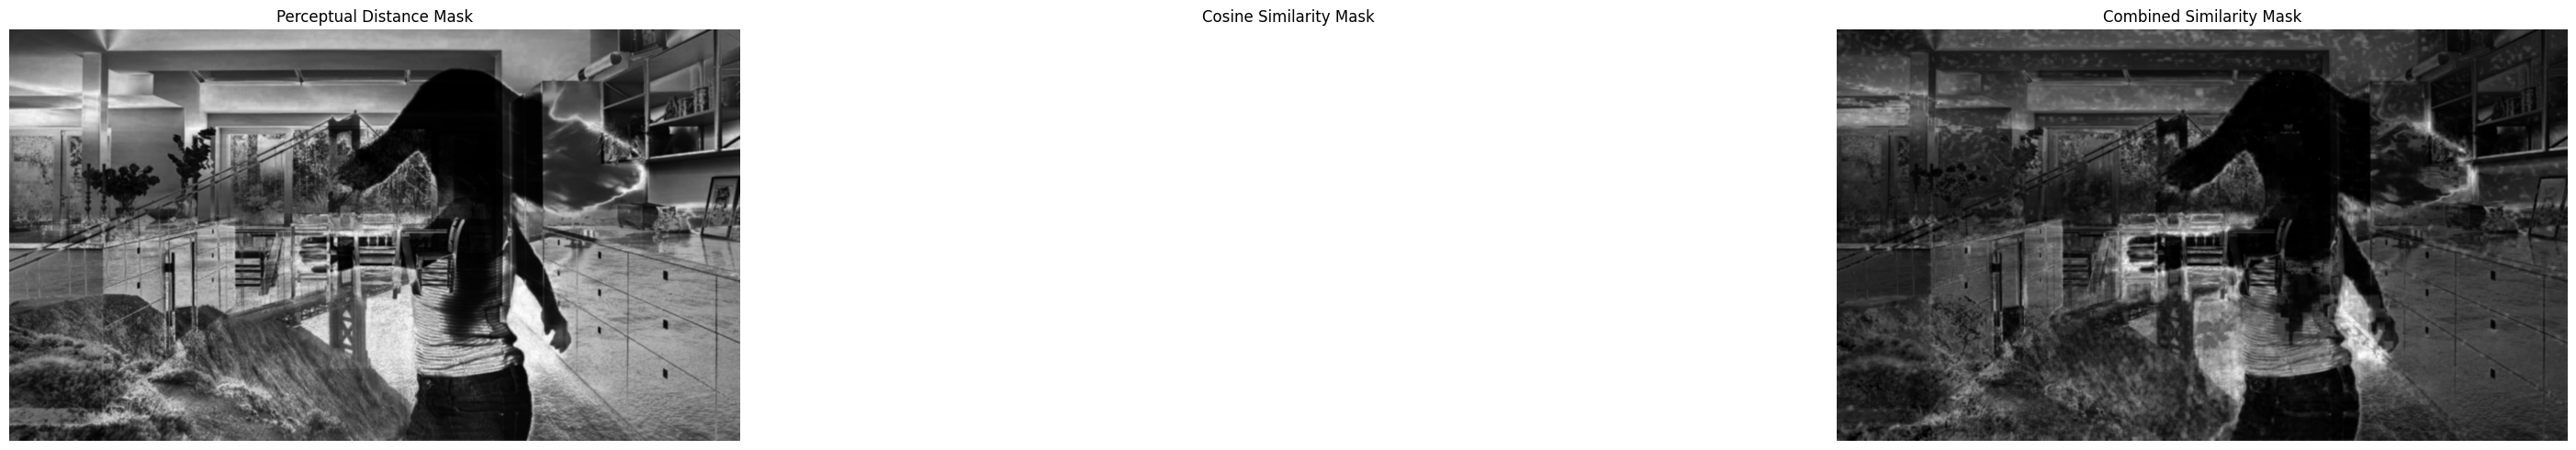

In [6]:
import matplotlib.pyplot as plt
first_frame = video["video"][290]
ground_truth_bg = video["background"]
background_mask_1 = create_continuous_similarity_mask(first_frame, ground_truth_bg, method="perceptual_distance")
# background_mask_2 = create_continuous_similarity_mask(first_frame, ground_truth_bg, method="cosine_similarity")
background_mask_3 = create_continuous_similarity_mask(first_frame, ground_truth_bg, method="combined")

plt.figure(figsize=(30, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB))
plt.title("First Frame")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(ground_truth_bg, cv2.COLOR_BGR2RGB))
plt.title("Ground Truth Background")
plt.axis('off')
plt.tight_layout()
plt.show()
plt.figure(figsize=(30, 5))
plt.subplot(1, 3, 1)
plt.imshow(background_mask_1, cmap='gray')
plt.title("Perceptual Distance Mask")
plt.axis('off')
plt.subplot(1, 3, 2)
# plt.imshow(background_mask_2, cmap='gray') # it takes too long
plt.title("Cosine Similarity Mask")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(background_mask_3, cmap='gray')
plt.title("Combined Similarity Mask")
plt.axis('off')
plt.tight_layout()
plt.show()

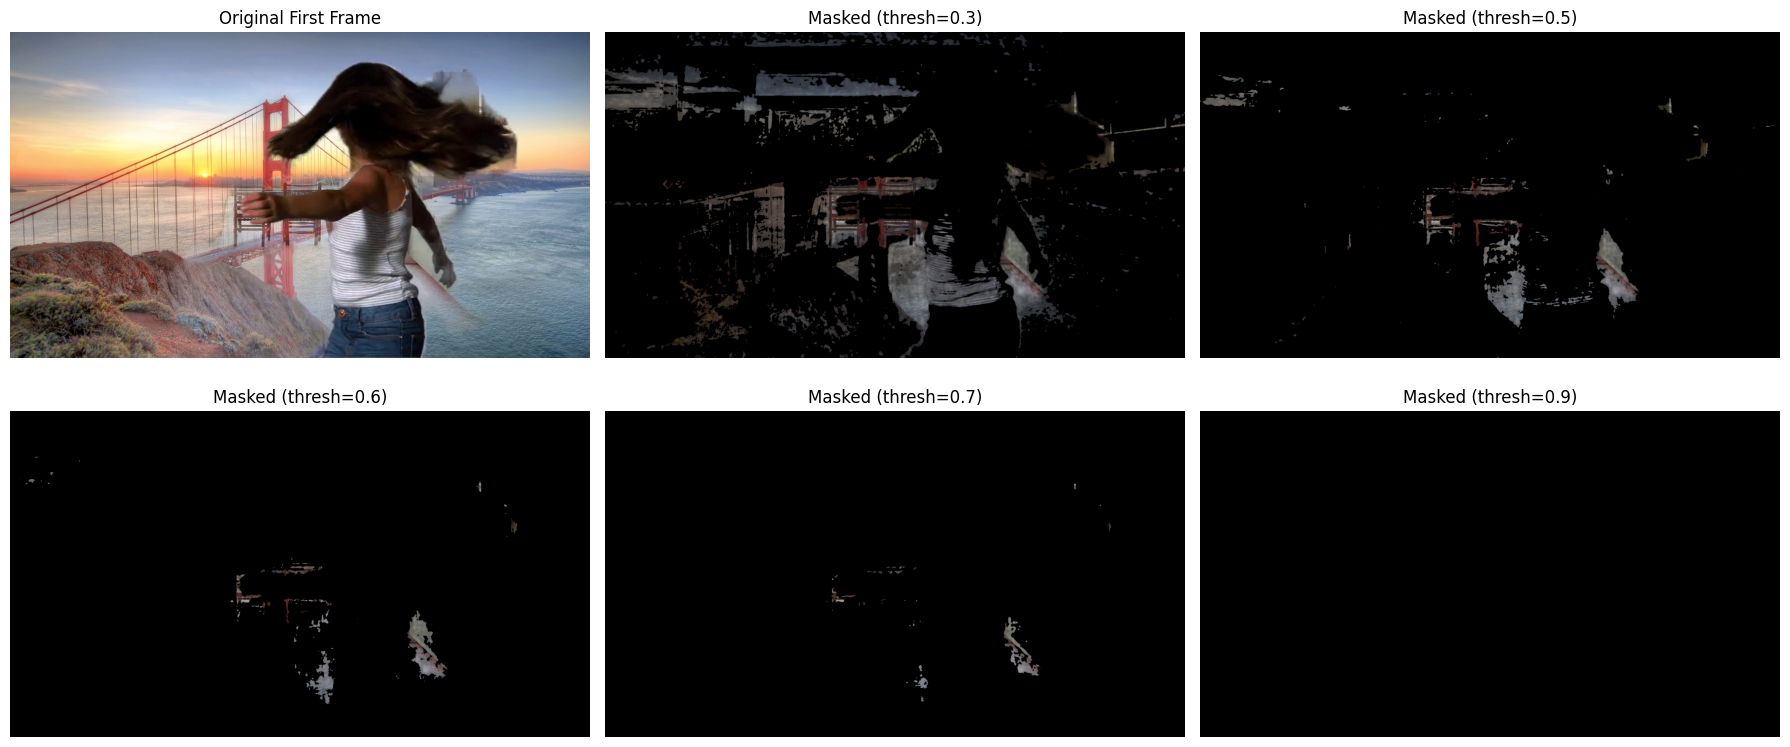

In [7]:
# adjust the visibility of each pixel of first_frame according to the value in background_mask_3 (background_mask_3 is of shape (720,1280) and the first_frame is of shape (720,1280,3))
def apply_mask_to_frame(frame, mask, threshold=0.6):
    """
    Apply a continuous similarity mask to a frame.
    Frame shape: (H, W, C)
    Mask shape: (H, W)
    Returns masked frame.
    """
    # Ensure mask is 3-channel for multiplication
    mask_3ch = np.stack([mask] * 3, axis=-1)
    # Threshold the mask: only keep values > 0.5, set others to 0
    mask_3ch = np.where(mask_3ch > threshold, mask_3ch, 0)
    # Apply mask to frame
    masked_frame = frame * mask_3ch
    
    return masked_frame

thresholds = [0.3, 0.5, 0.6, 0.7, 0.9]
plt.figure(figsize=(18, 8))
plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB))
plt.title("Original First Frame")
plt.axis('off')

for i, th in enumerate(thresholds):
    masked = apply_mask_to_frame(first_frame, background_mask_3, threshold=th)
    plt.subplot(2, 3, i + 2)
    plt.imshow(cv2.cvtColor(masked.astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.title(f"Masked (thresh={th})")
    plt.axis('off')

plt.tight_layout()
plt.show()


(720, 1280)
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [255 255 255 255 255 255 255 255 255 255]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [255 255 255 255 255 255 255 255 255 255]]


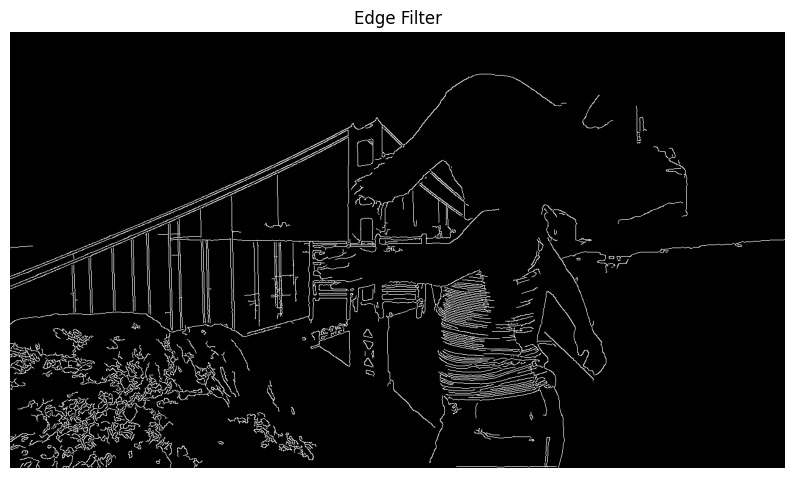

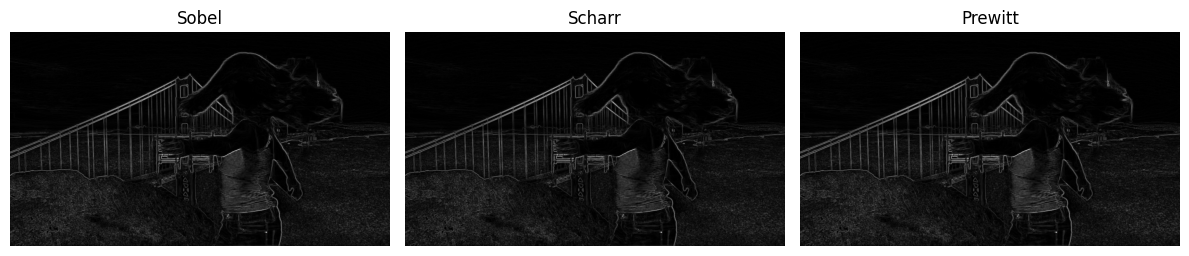

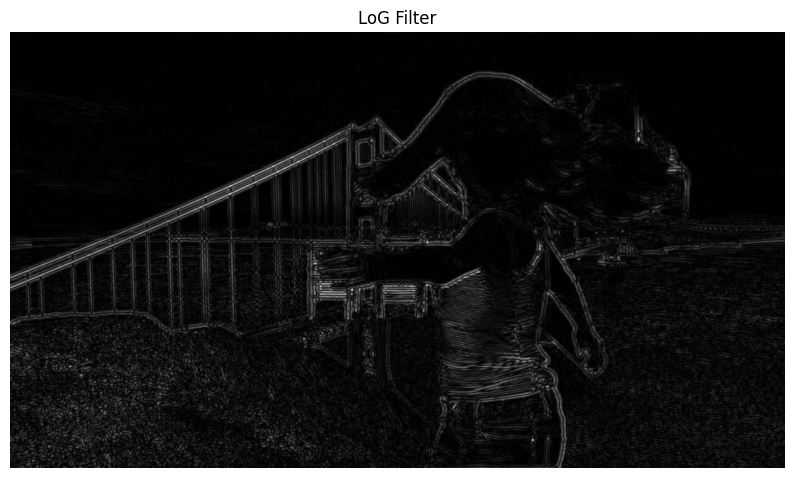

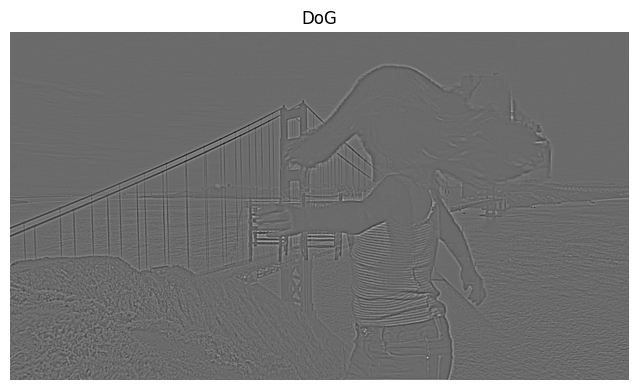

[[118 118 116 120 118 111 107 118 125 122]
 [109 109 109 111 111 102 102 111 118 116]
 [ 97  95  95  97  95  88  86  95 104 102]
 [ 88  86  84  86  84  77  75  84  91  86]
 [ 86  84  84  84  84  79  75  79  84  81]
 [100 102 102 102 102  97  93  95 100  97]
 [129 132 132 132 129 125 120 122 125 122]
 [143 143 141 141 141 134 129 132 136 138]
 [138 136 134 134 136 129 122 129 134 136]
 [113 111 111 111 111 107 100 107 113 113]]


In [8]:
def edge_filter(frame, low_threshold=50, high_threshold=150):
    # Convert to grayscale (first_frame is in RGB)
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    # Apply a Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Use Canny edge detector
    edges = cv2.Canny(blurred, low_threshold, high_threshold)
    return edges

edges_first_frame = edge_filter(first_frame)

print(edges_first_frame.shape)
print(edges_first_frame[340:350, 540:550])  # Print a small region to check
plt.figure(figsize=(10, 8))
plt.imshow(edges_first_frame, cmap='gray')
plt.title("Edge Filter")
plt.axis('off')
plt.show()


def sobel_filter(frame, ksize=3):
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    mag = np.hypot(gx, gy)
    return (mag / mag.max() * 255).astype(np.uint8)

def scharr_filter(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    gx = cv2.Scharr(gray, cv2.CV_64F, 1, 0)
    gy = cv2.Scharr(gray, cv2.CV_64F, 0, 1)
    mag = np.hypot(gx, gy)
    return (mag / mag.max() * 255).astype(np.uint8)

def prewitt_filter(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    # define Prewitt kernels
    kx = np.array([[ -1, 0, 1],
                   [ -1, 0, 1],
                   [ -1, 0, 1]], dtype=np.float32)
    ky = np.array([[ -1, -1, -1],
                   [  0,  0,  0],
                   [  1,  1,  1]], dtype=np.float32)
    gx = cv2.filter2D(gray.astype(np.float32), -1, kx)
    gy = cv2.filter2D(gray.astype(np.float32), -1, ky)
    mag = np.hypot(gx, gy)
    return (mag / mag.max() * 255).astype(np.uint8)

# Example visualization:
s = sobel_filter(first_frame)
sh = scharr_filter(first_frame)
p = prewitt_filter(first_frame)

plt.figure(figsize=(12,4))
for i,(img,title) in enumerate([(s,"Sobel"),(sh,"Scharr"),(p,"Prewitt")]):
    plt.subplot(1,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()

def log_filter(frame, ksize=5, sigma=1.0):
    """
    Laplacian of Gaussian (LoG) filter:
      1) Gaussian blur to reduce noise
      2) Laplacian operator to detect edges/blobs
    Args:
      frame: RGB image
      ksize: kernel size for both blur and Laplacian
      sigma: Gaussian standard deviation
    Returns:
      uint8 edge map in [0,255]
    """
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (ksize, ksize), sigma)
    log_resp = cv2.Laplacian(blurred, cv2.CV_64F, ksize=ksize)
    mag = np.abs(log_resp)
    return (mag / mag.max() * 255).astype(np.uint8)

# Example visualization:
l = log_filter(first_frame, ksize=7, sigma=1.4)
plt.figure(figsize=(10,10))
plt.imshow(l, cmap='gray')
plt.title("LoG Filter")
plt.axis('off')
plt.show()


# dog filter
def dog_filter(frame, ksize1=5, sigma1=1.0, ksize2=9, sigma2=2.0):
    """
    Difference of Gaussians (DoG):
      1) Blur with small σ
      2) Blur with large σ
      3) Subtract to highlight structures at scale between σ1 and σ2
    """
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    blur1 = cv2.GaussianBlur(gray, (ksize1, ksize1), sigma1)
    blur2 = cv2.GaussianBlur(gray, (ksize2, ksize2), sigma2)
    dog = blur1.astype(np.float32) - blur2.astype(np.float32)
    dog_norm = cv2.normalize(dog, None, 0, 255, cv2.NORM_MINMAX)
    return dog_norm.astype(np.uint8)

def gabor_filter_bank(frame,
                      ksize=31,
                      sigmas=(4.0,),
                      thetas=(0, np.pi/4, np.pi/2, 3*np.pi/4),
                      lambd=10.0,
                      gamma=0.5,
                      psi=0):
    """
    Apply a bank of Gabor filters at different orientations (θ) and scales (σ).
    Returns a list of response images.
    """
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    responses = []
    for sigma in sigmas:
        for theta in thetas:
            kernel = cv2.getGaborKernel(
                (ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F
            )
            # filter2D keeps depth same as source, so cast output back to uint8
            filtered = cv2.filter2D(gray, cv2.CV_32F, kernel)
            resp = cv2.normalize(filtered, None, 0, 255, cv2.NORM_MINMAX)
            responses.append(resp.astype(np.uint8))
    return responses

# Example visualization:
dog = dog_filter(first_frame, ksize1=5, sigma1=1.0, ksize2=9, sigma2=2.0)
g_resps = gabor_filter_bank(
    first_frame,
    ksize=31,
    sigmas=(2.0, 4.0),
    thetas=(0, np.pi/4, np.pi/2, 3*np.pi/4),
    lambd=8.0,
    gamma=0.5
)

plt.figure(figsize=(12,4))
# plt.subplot(1, 1+len(g_resps), 1)
plt.imshow(dog, cmap='gray')
plt.title('DoG')
plt.axis('off')
plt.tight_layout()
plt.show()
print(dog[340:350, 540:550])

# plt.figure(figsize=(12,4))
# # plt.subplot(1, len(g_resps), 1)
# plt.axis('off')
# for i, resp in enumerate(g_resps):
#     # plt.subplot(1, 1+len(g_resps), i+2)
#     plt.imshow(resp, cmap='gray')
#     plt.title(f'Gabor θ={np.round([0,np.pi/4, np.pi/2,3*np.pi/4][i%4],2)}')
#     plt.axis('off')
#     plt.tight_layout()
#     plt.show()

In [12]:
video["video"].shape, video["mask"].shape, video["background"].shape

((360, 720, 1280, 3), (720, 1280), (720, 1280, 3))

In [11]:
from scipy.stats import mode

# Compute the mode pixel value for each pixel across all frames and for each channel
# video["video"] has shape (num_frames, height, width, 3)
mode_image = mode(video["video"], axis=0)

In [21]:
type(mode_image[0]), mode_image[0].shape

(numpy.ndarray, (720, 1280, 3))

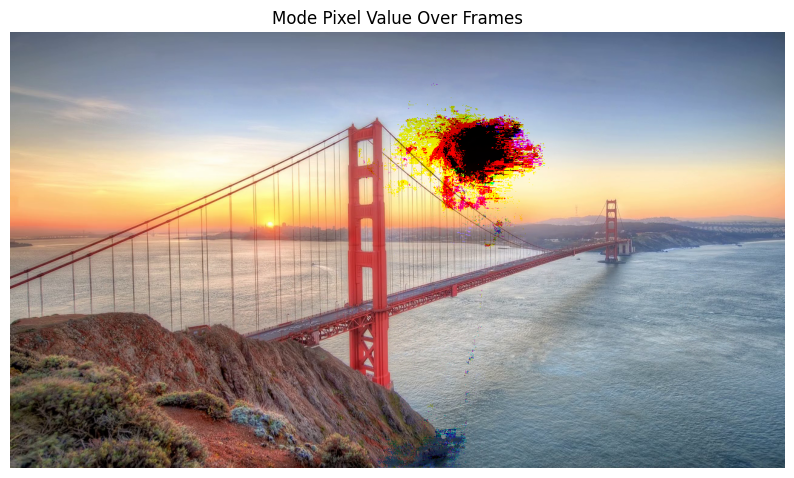

In [25]:
plt.figure(figsize=(10, 8))
# Convert from BGR to RGB for correct display
plt.imshow(mode_image[0][:,:,::-1])
plt.title("Mode Pixel Value Over Frames")
plt.axis('off')
plt.show()

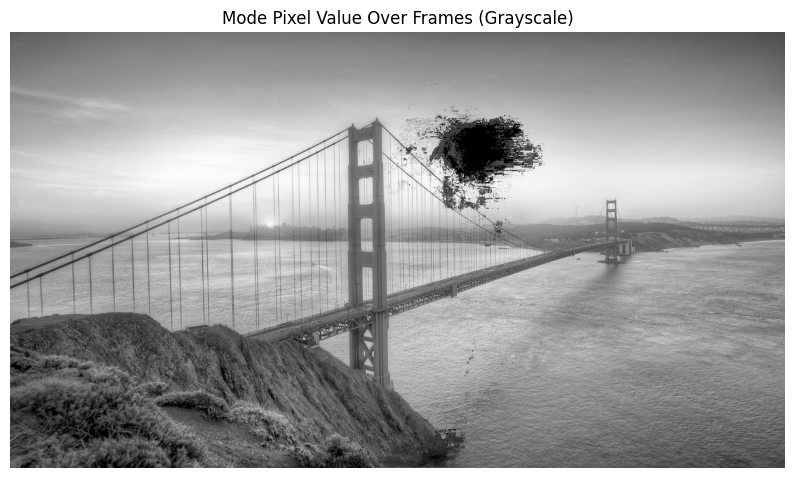

In [26]:
mode_img = mode_image[0].astype(np.uint8)
# turn to grayscale
mode_img_gray = cv2.cvtColor(mode_img, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10, 8))
plt.imshow(mode_img_gray, cmap='gray')
plt.title("Mode Pixel Value Over Frames (Grayscale)")
plt.axis('off')
plt.show()

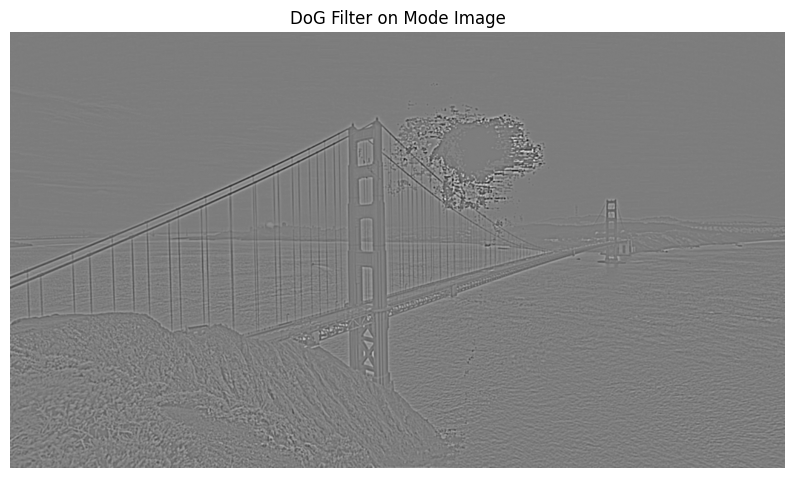

In [27]:
# create dog filter on mode_img
mode_img_dog = dog_filter(mode_img, ksize1=5, sigma1=1.0, ksize2=9, sigma2=2.0)
plt.figure(figsize=(10, 8))
plt.imshow(mode_img_dog, cmap='gray')
plt.title("DoG Filter on Mode Image")
plt.axis('off')
plt.show()